Launch the following blocks to connect to your drive and go into the tutorial folder

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My\ Drive/TD_Dreem_MasterBin/Dreem_Master_Bin
! ls

/content/gdrive/My Drive/TD_Dreem_MasterBin/Dreem_Master_Bin
data		  README.md		Tutorial_Sleep_Staging_A.ipynb
dreem_master_bin  README.rst		Tutorial_SleepStaging_B.ipynb
poetry.lock	  TD_SleepStaging_B.py
pyproject.toml	  tests


You are now in the right folder to import all the dependencies, which are functions and variables that you are going to use.

Here you will work with:
- numpy for array and vector computations
- matplotlib to plot your data
- datetime to handle date and time variable
- several functions from dreem_master_bin, made for this notebook


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix

from dreem_master_bin.utils import generate_timestamps_signals
from dreem_master_bin.load_data import get_one_record, list_record
from dreem_master_bin.spectrogram import plot_spectrogram
from dreem_master_bin.hypnogram import plot_hypnogram, stage_colors
from dreem_master_bin.accelerometer import plot_accelerometer, compute_movement_variance

In the folder Dreem_Master_Bin/data/Records, you can find several .h5 files.
Each of this files correspond to one sleep record. It contains :
- EEG data (1 fronto-occipital channel)
- Hypnogram 
- Accelerometer data
- Spectral data (computed for this exercise)
- sampling frequency (250Hz)
- start time of the record

Let's look at it !


Let's plot the EEG signal:

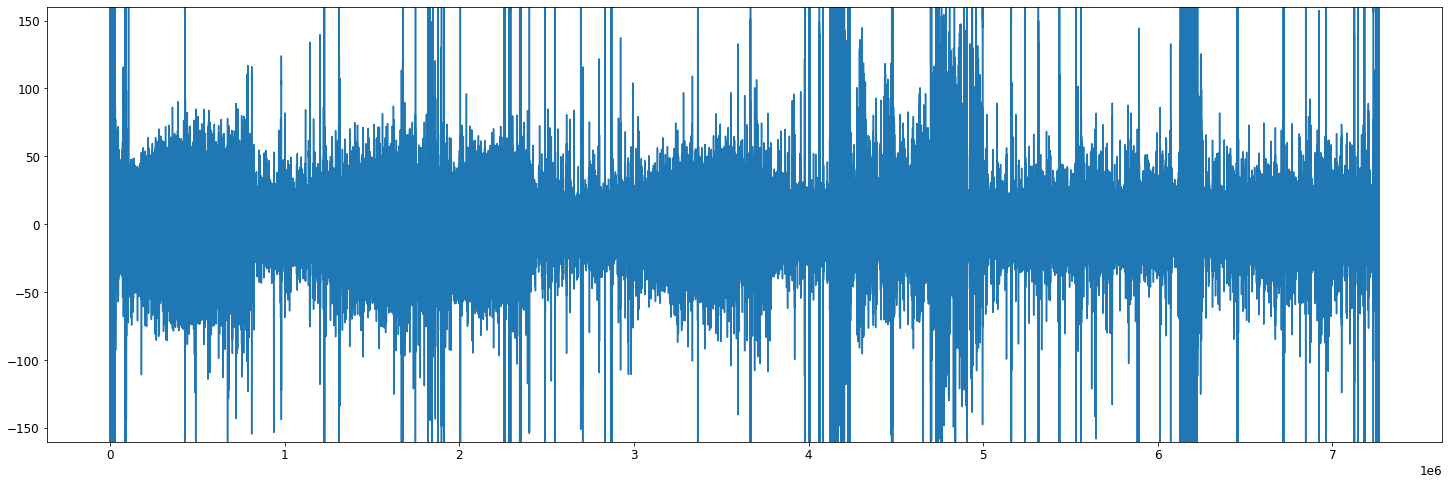

In [4]:
# let's load the first record
record = list_record[0]
eeg = get_one_record(record)['eeg']

# plot it !
plt.figure(figsize=(25, 8))
plt.plot(eeg)
plt.ylim([-160, 160])
plt.show()

This the raw visualization of one EEG channel F7-01 (fronto-occipital) during a whole night sleep.
We can add more interesting visualizations of sleep data:

- EEG raw signal
- EEG spectrogram (time-frequency representation)
- Movement (computed from the variance of the accelerometer data)
- Hypnogram (sleep stages)

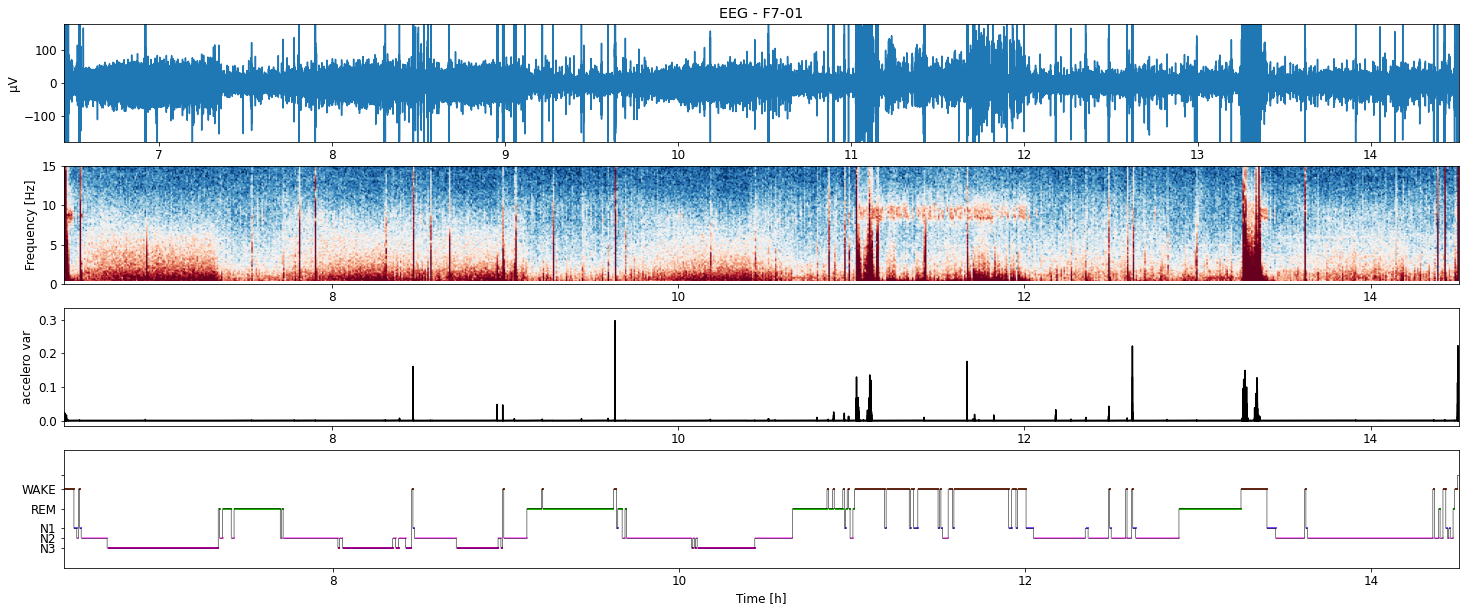

In [5]:
# get data
results = get_one_record(record)
eeg = results['eeg']
accelerometer = results['accelerometer']
hypnogram = results['hypnogram']
spectrogram, t_specg, freq_specg = results['spectrogram'], results['t'], results['freq']
fs = results['fs']
start_time = datetime.fromtimestamp(results['start_time'])

# accelerometer is a 3D-array (x, y ,z)
# we compute its variance > movement
mov_variance, fs_accelero = compute_movement_variance(np.transpose(accelerometer), fs=50., buff_len_sec=1, computation_delay=0.1)
t_accelero = np.arange(0,len(mov_variance)) / fs_accelero

# Generate the figure with 4 axes
rescale = 3600  # from sec to hour
fig, axs = plt.subplots(4, 1, figsize=(25, 10))
axs = np.ravel(axs)

# EEG raw data
ax = axs[0]
t = generate_timestamps_signals(eeg, fs, start_time) / rescale

ax.plot(t, eeg)
ax.set_ylim([-180, 180])
ax.set_ylabel('µV')
ax.set_title('EEG - F7-01')

# spectrogram channel 1
plot_spectrogram(spectrogram, t_specg, freq_specg, axe_plot=axs[1], rescale=rescale,
                        start_time=start_time, title='')

# accelerometer
plot_accelerometer(mov_variance, axe_plot=axs[2], fs=fs_accelero,
                            rescale=rescale, start_time=start_time, title='')

# same xlim for each axes
axs[2].set_xlim(axs[1].get_xlim())
axs[0].set_xlim(axs[1].get_xlim())

# hypnogram
hyp = plot_hypnogram(hypnogram, axe_plot=axs[3], binsize=30,
                        rescale=rescale, start_time=start_time, title='')
hyp.set_xlabel('Time [h]')

# Display
fig.show()


Let's look at each of the 4 records:

In [6]:
for record in list_record:
    # get data
    results = get_one_record(record)
    eeg = results['eeg']
    accelerometer = results['accelerometer']
    hypnogram = results['hypnogram']
    spectrogram, t_specg, freq_specg = results['spectrogram'], results['t'], results['freq']
    fs = results['fs']
    start_time = datetime.fromtimestamp(results['start_time'])

    # accelerometer is a 3D-array (x, y ,z)
    # we compute its variance > movement
    mov_variance, fs_accelero = compute_movement_variance(np.transpose(accelerometer), fs=50., buff_len_sec=1, computation_delay=0.1)
    t_accelero = np.arange(0,len(mov_variance)) / fs_accelero

    # Generate the figure with 4 axes
    rescale = 3600  # from sec to hour
    fig, axs = plt.subplots(4, 1, figsize=(25, 10))
    axs = np.ravel(axs)

    # EEG raw data
    ax = axs[0]
    t = generate_timestamps_signals(eeg, fs, start_time) / rescale

    ax.plot(t, eeg)
    ax.set_ylim([-180, 180])
    ax.set_ylabel('µV')
    ax.set_title('Record ' + str(record) + ' (EEG - F7-01)')

    # spectrogram channel 1
    plot_spectrogram(spectrogram, t_specg, freq_specg, axe_plot=axs[1], rescale=rescale,
                            start_time=start_time, title='')

    # accelerometer
    plot_accelerometer(mov_variance, axe_plot=axs[2], fs=fs_accelero,
                                rescale=rescale, start_time=start_time, title='')

    # same xlim for each axes
    axs[2].set_xlim(axs[1].get_xlim())
    axs[0].set_xlim(axs[1].get_xlim())

    # hypnogram
    hyp = plot_hypnogram(hypnogram, axe_plot=axs[3], binsize=30,
                            rescale=rescale, start_time=start_time, title='')
    hyp.set_xlabel('Time [h]')

    # Display
    fig.show()

Output hidden; open in https://colab.research.google.com to view.

What do we see:
- Movement occured mainly during wake periods 
- Noisy signals during movement
- Low frequency power: N3 > N2 > N1-REM-Wake

It seems possible to classify sleep stages from time-frequency representations.
What is then the average spectrum for each substage?

- Spectrogram are the time-frequency matrix z = P(t, f)
- Spectrum correspond to the curves y = P(frequency)

Average Spectrum can therefore be computed as the mean of spectromgram over a specified period.

Let's plot them:

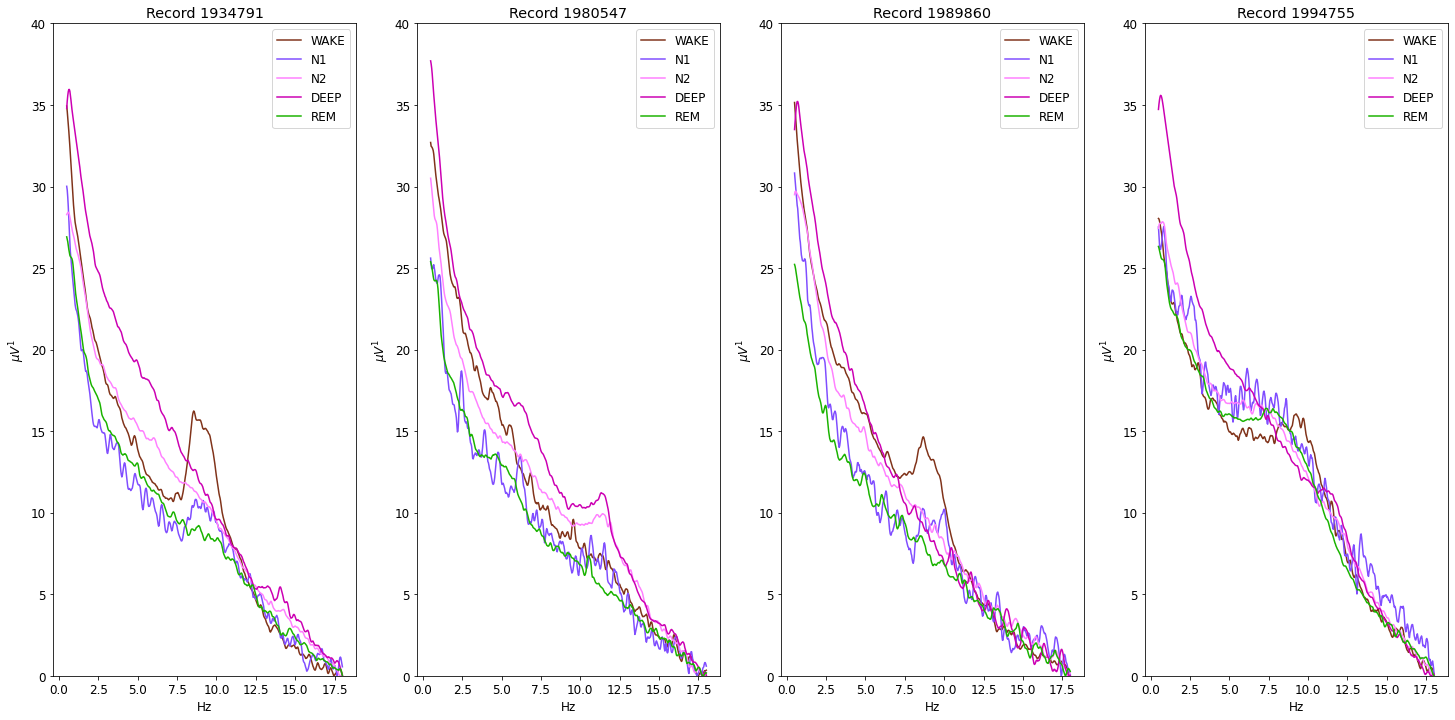

In [7]:
# compute and plot the average spectrum for each sleep stages
stage_correspondance = {0: "WAKE", 1: "N1", 2: "N2", 3: "DEEP", 4: "REM"}

# generate figure: one graph per record
fig, axs = plt.subplots(1, len(list_record), figsize=(25, 12))
axs = np.ravel(axs)

for i, record in enumerate(list_record):
    # get data
    results = get_one_record(record)
    hypnogram = results['hypnogram']
    spectrogram, t_specg, freq_specg = results['spectrogram'], results['t'], results['freq']

    ax = axs[i]
    for stage, stage_label in stage_correspondance.items():
        # average spectrogram on each sleep stage period
        idx = np.isin(hypnogram, stage)
        spectrogram_stage = spectrogram[:, idx]
        avg_spectrum = np.mean(spectrogram_stage, 1)

        # normalize signals, you could:
        #    - substract the minimum value to have the minimum at 0
        #    - divide by the max to have the max at 1
        #    - substract the mean...
        avg_spectrum -= np.min(avg_spectrum)

        # plot
        ax.plot(freq_specg, avg_spectrum, color=stage_colors[stage])
        ax.set_ylabel('$µV^1$')
        ax.set_xlabel('Hz')
        ax.set_ylim([0, 40])
        ax.set_title('Record ' + str(record))

    ax.legend(stage_correspondance.values(), loc='upper right')

# display
fig.show()

From these average spectrum graphs, can you find some rules to classify sleep stages ?

> Fill the *find_stage_from_spectrum* below.


In [8]:
# put your rules in this function
def find_stage_from_spectrum(spectrum, freq):
    # by default the value is -1
    stage = -1

    # write the rules for each substage
    if 1:
        stage = 0
    elif 1: 
        stage = 1
    elif 1: 
        stage = 2
    elif 1: 
        stage = 3
    else:
        stage = 4

    return stage



Get your classification scores: this script uses your algorithm to predict sleep stages from the spectrogram of each record.

The scores are:
- Balanced accuracy: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
- Cohen Kappa: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score
- Confusion matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

In [9]:
# test your algorithms on data
predictions = []
true_labels = []
for i, record in enumerate(list_record):
    # get data
    hypnogram = results['hypnogram']
    spectrogram, _, freq_specg = results['spectrogram'], _, results['freq']

    true_labels += list(hypnogram)
    predictions += [find_stage_from_spectrum(spectrum, freq_specg) for spectrum in np.transpose(spectrogram)]


# Get your scores
scores = {}
scores['balanced_accuracy'] = balanced_accuracy_score(true_labels, predictions)
scores['cohen_kappa'] = cohen_kappa_score(true_labels, predictions)
scores['confusion_matrix'] = confusion_matrix(true_labels, predictions)

print(scores)

{'balanced_accuracy': 0.2, 'cohen_kappa': 0.0, 'confusion_matrix': array([[ 256,    0,    0,    0,    0],
       [  44,    0,    0,    0,    0],
       [1140,    0,    0,    0,    0],
       [1316,    0,    0,    0,    0],
       [1004,    0,    0,    0,    0]])}


As you see, it is not obvious to find rules to classify sleep stages automatically. It can take some times and there are too much patterns to take into account.

Thus, we are going to adress the machine learning methods in the next part.

Open the **Tutorial_Sleep_Staging_B.ipynb** tutorial
